# Facial Expression Recognition
**Nhóm 10**<br>
Bùi Quốc Bảo - 1412034 <br>
Vũ Ngọc Minh Hoàng - 1412186 <br>
Lưu Đức Hiếu - 1412161



## 1. Mục tiêu của chương trình:

Thiết lập một thuật toán có thể nhận dạng được 7 biểu hiện của nét mặt người bao gồm: Giận dữ, kinh tởm, sợ hãi, hạnh phúc, buồn, ngạc nhiên, trung lập.

## 2. Miêu tả tập dữ liệu:

Tập dữ liệu bao gồm những hình ảnh grayscale kích cỡ 48x48. Khuôn mặt đã được tự động cân chỉnh sao cho nó nằm ở chính giữa khung hình và chiếm một diện tích xấp xỉ nhau ở mỗi bức ảnh. Bộ dữ liệu gồm có bảy phân lớp tượng trưng cho bảy biểu hiện cảm xúc của con người: 
- 0 = Giận dữ
- 1 = Kinh tởm
- 2 = Sợ hãi
- 3 = Hạnh phúc
- 4 = Buồn
- 5 = Ngạc nhiên
- 6 = Trung lập <br>

Tập tin **fer2013.csv** gồm ba cột: **emotion**, **pixels**, **Usage**. Cột **emotion** chứa giá trị từ 0 đến 6 tượng trưng cho biểu cảm trong hình. Cột **pixels** chứa một chuỗi tượng trưng cho giá trị của từng điểm ảnh trong hình theo thứ tự từng cột, mỗi giá trị trong chuỗi này được cách nhau bằng dấu cách. Cột **Usage** cho chúng ta biết đây là tập dữ liệu gì, gồm có ba giá trị: PrivateTest, PublicTest, Training. PublicTest có thể gọi là tập validation, PrivateTest là tập mà chúng ta sẽ dùng để kiểm tra khi hoàn tất việc huấn luyện mô hình.<br>

Tập huấn luyện bao gồm **28709** mẫu. Tập PublicTest và tập PrivateTest mỗi tập sẽ có **3589** mẫu. Bộ dữ liệu này được tạo bởi Pierre-Luc Carrier và Aaron Courville, là một phần của dự án nghiên cứu nhận dạng biểu cảm khuôn mặt người. Tập dữ này được sử dụng cho một cuộc thi trên trang web [kaggle.com](http://kaggle.com)

## 3. Tổng quan của chương trình:
- ### Tiền xử lý dữ liệu:
    - Sử dụng phương pháp tiền xử lý dữ liệu trong bài báo thắng giải cuộc thi nhận dạng biểu cảm khuôn mặt người trên trang web Kaggle (http://deeplearning.net/wp-content/uploads/2013/03/dlsvm.pdf). Cụ thể hơn:
        - Trừ giá trị trung bình của từng bức ảnh và chuẩn hóa bức ảnh về trong khoảng từ 0 đến 100.
        - Từng điểm ảnh được chuẩn hóa bằng cách trừ giá trị trung bình của từng điểm ảnh và chia cho độ lệch chuẩn của điểm ảnh đó.
- ### Mô hình sử dụng trong chương trình:
    - Sử dụng mô hình **Convolutional Neural Network** để học biểu cảm khuôn mặt người với đầu vào là một ma trận chứa dãy điểm ảnh của từng bức hình và đầu ra là các số từ 0 đến 6 tượng trưng cho từng biểu cảm.
    - Sử dụng kiến trúc LeNet kinh điển của Convolutional Neural Network 
với hai lớp convolutional layer, hai lớp kích hoạt, hai lớp pooling và theo sau đó là hai fully-connected layers rồi cuối cùng là một hàm softmax.
    - Sử dụng hàm tối ưu Adam, hàm chi phi là cross entropy và sử dụng phương pháp decay learning rate trên batch size là 800. Ngoài ra còn sử dụng phương pháp Dropout để regularize mô hình.
    - Chương trình được code bằng ngôn ngữ **Python**, sử dụng framework **Tensorflow**. Mô hình sẽ được huấn luyện trên GPU GTX 1060 6Gb.

   <center> **Kiến trúc LeNet** </center>
   <img src="Images/LeNet5.png" />

## 4. Chi tiết chương trình:

- ### Pickle File:
    - Sử dụng phương thức đọc ghi dữ liệu của python để tạo ra các file chứa dữ liệu đã được tiền xử lý. Có 5 phương thức tiền xử lý được được đánh số từ 0 đến 4. Trong đó:
        - 0: Các tiền xử lý trong bài báo được nêu trên
        - 1: StandardScaler
        - 2: Normalizer
        - 3: MaxAbsScaler
        - 4: MinMaxScaler
    - Chương trình cho kết quả tốt nhất với cách thức tiền xử lý số 0 nên chúng ta sẽ sử dụng cách đó ở đây

- ### Load Pickle file:
    - Sau khi đã hoàn thành xong việc ghi dữ liệu đã được tiền xử lý, chúng ta load nó lại như sau:

- ### Tiền xử lý theo bài báo:
    - Để chuẩn hóa hình ảnh từ khoảng giá trị 0-255 về khoảng 0-100, ta sử dụng công thức sau:<br>
    <center><img src="Images/ImageNorm.png"/></center>
    - Với Min = 0, Max = 255, newMin = 0, newMax = 100, ta được:
    $$I_N = I.\frac{100}{255}$$
    - Vậy cơ bản ta chỉ cần nhân từng điểm ảnh cho $\frac{100}{255}$

In [5]:
import tensorflow as tf
import numpy as np
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import os
import sys


def reformat(dataset, labels):
    dataset = dataset.reshape(
        -1, image_size, image_size, num_channels)

    # Convert labels to one hot encoding
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels


def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


def showImage(data):
    data = data.reshape(image_size, image_size)
    plt.imshow(data, cmap="gray")
    plt.show()

In [6]:
preprocess_flag = 0
pickle_file = "Data/facial_reg_{}.pickle".format(preprocess_flag)
with open(pickle_file, 'rb') as f:
    try:
        save = pickle.load(f)
        train_dataset = save['train_dataset']
        train_labels = save['train_labels']
        valid_dataset = save['valid_dataset']
        valid_labels = save['valid_labels']
        test_dataset = save['test_dataset']
        test_labels = save['test_labels']
        del save  # hint to help gc free up memory
        print('Training set', train_dataset.shape, train_labels.shape)
        print('Validation set', valid_dataset.shape, valid_labels.shape)
        print('Test set', test_dataset.shape, test_labels.shape)
    except:
        print("Unable to load file")
        exit()


Training set (28709, 2304) (28709,)
Validation set (3589, 2304) (3589,)
Test set (3589, 2304) (3589,)


- Chúng ta sẽ chuyển tập dữ liệu từ hình dạng [số tập dữ liệu, 48x48] thành [số tập dữ liệu, 48, 48, 1] để làm input đầu vào cho convolutional neural network

In [7]:
image_size = 48
num_labels = 7
num_channels = 1 # grayscale
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

- Chúng ta có thể xem hình ảnh từ một tập dữ liệu bất kì

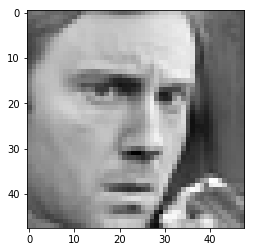

In [4]:
showImage(train_dataset[0])

- Chúng ta bắt đầu xây dựng mô hình:

In [8]:
batch_size = 800
patch_size = 5
depth = 64
num_hidden = 128

graph = tf.Graph()

with graph.as_default():

    # Input data
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))

    # Drop out holder
    keep_prob = tf.placeholder(dtype=tf.float32)

    # Variables
    layer1_weights = tf.get_variable("layer1_weights", shape=[patch_size, patch_size, num_channels, depth],
                                     initializer=tf.random_normal_initializer(stddev=0.1))
    layer1_biases = tf.get_variable("layer1_biases", shape=[depth], initializer=tf.constant_initializer(0))

    layer2_weights = tf.get_variable("layer2_weights", shape=[patch_size, patch_size, depth, num_hidden],
                                     initializer=tf.random_normal_initializer(stddev=0.1))
    layer2_biases = tf.get_variable("layer2_biases", shape=[num_hidden], initializer=tf.constant_initializer(0))

    # Divide by 4 here, as images have been halved twice during max pooling steps
    layer3_weights = tf.get_variable("layer3_weights", shape=[image_size // 4 * image_size // 4 * num_hidden, 3100],
                                     initializer=tf.random_normal_initializer(stddev=0.1))
    layer3_biases = tf.get_variable("layer3_biases", shape=[3100], initializer=tf.constant_initializer(0))

    layer4_weights = tf.get_variable("layer4_weights", shape=[3100, 1500],
                                     initializer=tf.random_normal_initializer(stddev=0.1))
    layer4_biases = tf.get_variable("layer4_biases", shape=[1500], initializer=tf.constant_initializer(0))

    layer5_weights = tf.get_variable("layer5_weights", shape=[1500, num_labels],
                                     initializer=tf.random_normal_initializer(stddev=0.1))
    layer5_biases = tf.get_variable("layer5_biases", shape=[num_labels], initializer=tf.constant_initializer(0))

    # Model.
    def model(data):
        # Convolution in the first layer has to keep the same shape as the input so the stride is [1, 1, 1, 1]
        # and padding must be SAME to keep the conv width and height equal to width and height in the input
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)

        # Reduce the dimensionality by using the max pool operation here with kernel size 2 and stride 2
        maxpool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        conv = tf.nn.conv2d(maxpool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)

        # Add drop out here
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        shape = hidden.get_shape().as_list()

        # Fully connected layer, batch_size x total_features
        # Rollout height, width and feature_map into total features
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, layer4_weights) + layer4_biases)
        hidden2 = tf.nn.dropout(hidden2, keep_prob)
        return tf.matmul(hidden2, layer5_weights) + layer5_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

    # Just a number of time the model update the weight which means the number of batches the optimizer
    # has seen
    global_step = tf.Variable(0, trainable=False, name="global_step")

    # Add learning decay here
    # Here is the decay learning rate formula:
    # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay(learning_rate=1e-4, global_step=global_step, decay_rate=0.96,
                                               decay_steps=100000, staircase=True)
    #learning_rate = 1e-4
    saver = tf.train.Saver(max_to_keep=5)

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

- Sau đó chúng ta chạy mô hình trên:

In [6]:
num_steps = 1000
training_accuracies = []
validation_accuracies = []
test_prediction_labels = None
x_range = []
step_per_checkpoint = 100
train_dir = "Checkpoints"
test_batch_range = 0

if not os.path.exists(train_dir):
    print("Creating training directory")
    os.makedirs(train_dir)

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(train_dir)
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        saver.restore(session, tf.train.latest_checkpoint(train_dir))
        print("Loading from checkpoint %d" % global_step.eval())
    else:
        print('Initializing with fresh parameters')
    for step in range(0, num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {keep_prob: 0.5, tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if global_step.eval() % 50 == 0:
            print("Minibatch loss at step %d: %f" % (global_step.eval(), l))
            train_accuracy = accuracy(train_prediction.eval(feed_dict={keep_prob: 1.0, tf_train_dataset: batch_data}),
                                      batch_labels)
            training_accuracies.append(train_accuracy)
            print("Minibatch accuracy: %.1f%%" % train_accuracy)

            val_accuracy = 0
            offset = 0
            val_batch_range = int(valid_labels.shape[0] / batch_size)
            for val_step in range(0, val_batch_range):
                # We have to calculate accuracy on small batch to prevent GPU memory exhaust
                val_batch_data = valid_dataset[offset:(offset + batch_size), :, :, :]
                val_batch_labels = valid_labels[offset:(offset + batch_size), :]

                # In validation and test sets we do not add drop out so keep_prob will be 1
                val_accuracy += accuracy(valid_prediction.eval(feed_dict={keep_prob: 1.0,
                                                                         tf_valid_dataset: val_batch_data}), val_batch_labels)
                offset += batch_size
            val_accuracy /= val_batch_range
            validation_accuracies.append(val_accuracy)
            print('Validation accuracy: %.1f%%' % val_accuracy)
            x_range.append(global_step.eval())
        if global_step.eval() % step_per_checkpoint == 0:
            print("Saving model at %d steps" % global_step.eval())
            checkpoint_path = os.path.join(train_dir, "cnnmodel")
            saver.save(session, checkpoint_path, global_step=global_step.eval(), write_meta_graph=False)

    test_batch_range = int(test_labels.shape[0] / batch_size)
    test_accuracy = 0
    offset = 0
    for test_step in range(0, test_batch_range):
        test_batch_data = test_dataset[offset:(offset + batch_size), :, :, :]
        test_batch_labels = test_labels[offset:(offset + batch_size), :]
        test_pred = test_prediction.eval(feed_dict={keep_prob: 1.0, tf_test_dataset: test_batch_data})
        if test_prediction_labels is None:
            test_prediction_labels = test_pred
        else:
            test_prediction_labels = np.concatenate((test_prediction_labels, test_pred), axis=0)
        test_accuracy += accuracy(test_pred, test_batch_labels)
    test_accuracy /= test_batch_range
    print('Test accuracy: %.1f%%' % test_accuracy)

INFO:tensorflow:Restoring parameters from Checkpoints\cnnmodel-22600
Loading from checkpoint 22600
Minibatch loss at step 22650: 0.018435
Minibatch accuracy: 100.0%
Validation accuracy: 54.2%
Minibatch loss at step 22700: 0.020790
Minibatch accuracy: 99.9%
Validation accuracy: 54.4%
Saving model at 22700 steps
Minibatch loss at step 22750: 0.034519
Minibatch accuracy: 99.4%
Validation accuracy: 53.5%
Minibatch loss at step 22800: 0.017338
Minibatch accuracy: 99.9%
Validation accuracy: 53.8%
Saving model at 22800 steps
Minibatch loss at step 22850: 0.015442
Minibatch accuracy: 99.9%
Validation accuracy: 54.0%
Minibatch loss at step 22900: 0.020882
Minibatch accuracy: 99.8%
Validation accuracy: 54.2%
Saving model at 22900 steps
Minibatch loss at step 22950: 0.014084
Minibatch accuracy: 100.0%
Validation accuracy: 54.1%
Minibatch loss at step 23000: 0.014825
Minibatch accuracy: 99.8%
Validation accuracy: 53.5%
Saving model at 23000 steps
Minibatch loss at step 23050: 0.013408
Minibatch ac

- Từ đó ta có thể biểu diễn độ chính xác của mô hình:

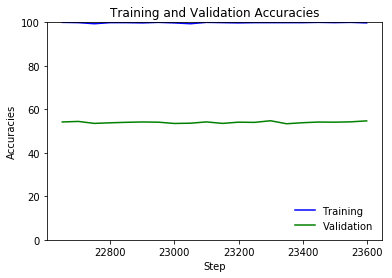

In [7]:
def plotAccuracies(train_acc, val_acc, x_range):
    plt.plot(x_range, train_acc, '-b', label="Training")
    plt.plot(x_range, val_acc, '-g', label="Validation")
    plt.legend(loc="lower right", frameon=False)
    plt.ylim(ymin=0.0, ymax=100.0)
    plt.ylabel("Accuracies")
    plt.xlabel("Step")
    plt.title("Training and Validation Accuracies")
    plt.show()


def plotConfusionMatrix(cm, classes, normalize=False, title="Confusion matrix"):
    if normalize:
        print("Normalized confusion matrix")
        # This is the same as cm.astype("float") / cm.sum(axis=1).reshape(-1, 1)
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > threshold
                 else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

plotAccuracies(training_accuracies, validation_accuracies, x_range)

- Hoặc chúng ta có thể vẽ confusion matrix:

Confusion matrix, without normalization
[[ 70   2  48 127  69  30  82]
 [  5   6   6  18   5   5   7]
 [ 50   3  84 130  63  31 109]
 [ 54   5  88 352  92  48 156]
 [ 56   0  65 125 112  45 126]
 [ 30   1  40 111  45  76  64]
 [ 55   3  53 141  86  37 184]]


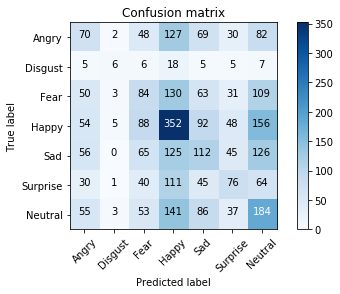

In [8]:
# Sorted order according to the data description
class_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
confusionmatrix = confusion_matrix(np.argmax(test_labels[:(test_batch_range*batch_size)], axis=1),
                                   np.argmax(test_prediction_labels, axis=1))
plotConfusionMatrix(confusionmatrix, class_labels, False)

- Ta thử sử dụng phương pháp SVM căn bản để làm baseline so sánh với kết quả ta vừa tìm được:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import pandas as pd
from data_util import convertData

df = pd.read_csv("Data/fer2013/fer2013.csv")
preprocess_flag = 0

# Train dataset
train_dataset = df[df["Usage"] == "Training"]
train_data = convertData(train_dataset.loc[:, "pixels"], preprocess_flag)
pca = PCA(n_components=150, svd_solver='randomized',
          whiten=True).fit(train_data)
train_data = pca.transform(train_data)
train_labels = train_dataset.loc[:, "emotion"].values.ravel()

# Valid dataset
valid_dataset = df[df.Usage == "PublicTest"]
valid_dataset.reset_index(inplace=True)
valid_data = convertData(valid_dataset.loc[:, "pixels"], preprocess_flag)
valid_data = pca.transform(valid_data)
valid_labels = valid_dataset.loc[:, "emotion"].values.ravel()

# Test dataset
test_dataset = df[df.Usage == "PrivateTest"]
test_dataset.reset_index(inplace=True)
test_data = convertData(test_dataset.loc[:, "pixels"], preprocess_flag)
test_data = pca.transform(test_data)
test_labels = test_dataset.loc[:, "emotion"].values.ravel()

param_grid = {'C': [1e3],
              'gamma': [0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(train_data, train_labels)
y_pred = clf.predict(valid_data)
print(classification_report(valid_labels, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.08      0.14       467
          1       1.00      0.27      0.42        56
          2       0.92      0.10      0.18       496
          3       0.27      1.00      0.43       895
          4       0.88      0.06      0.11       653
          5       0.97      0.29      0.45       415
          6       0.68      0.06      0.10       607

avg / total       0.71      0.33      0.25      3589



In [5]:
print(confusion_matrix(valid_labels, y_pred, labels=range(7)))

[[ 37   0   0 425   3   0   2]
 [  1  15   0  40   0   0   0]
 [  1   0  49 435   1   4   6]
 [  1   0   0 891   0   0   3]
 [  4   0   2 606  38   0   3]
 [  0   0   2 289   0 122   2]
 [  0   0   0 572   1   0  34]]


- Từ confusion matrix ta có thể tính được độ chính xác của mô hình SVM này là: **33%**

## Kiểm tra độ chính xác của chương trình:
- Sau khi đã tính được độ chính xác của chương trình, ta bắt đầu kiểm tra độ chính xác ấy bằng cách so sánh hình ảnh với nhãn của tập dữ liệu **PrivateTest** và nhãn mà mô hình tốt nhất dự đoán được:

INFO:tensorflow:Restoring parameters from Checkpoints\cnnmodel-23600
Loading from the checkpoint 23600
Showing image 0


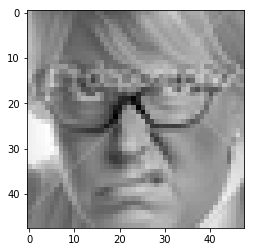

True label: Angry
Predicted label: Angry

Showing image 1


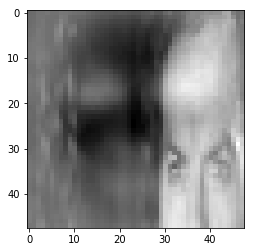

True label: Surprise
Predicted label: Sad

Showing image 2


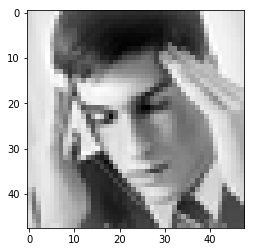

True label: Neutral
Predicted label: Sad

Showing image 3


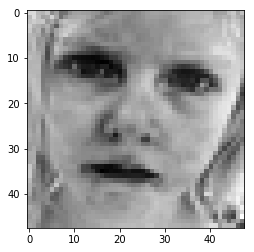

True label: Sad
Predicted label: Sad

Showing image 4


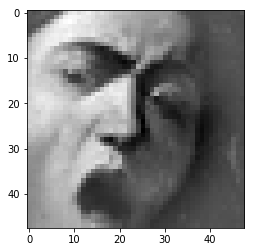

True label: Fear
Predicted label: Neutral

Showing image 5


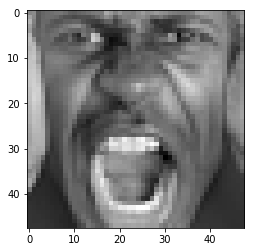

True label: Angry
Predicted label: Surprise

Showing image 6


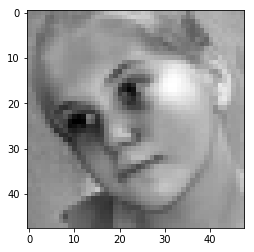

True label: Sad
Predicted label: Neutral

Showing image 7


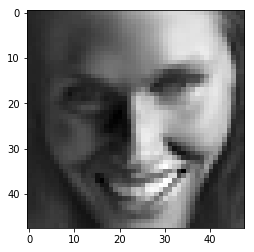

True label: Happy
Predicted label: Happy

Showing image 8


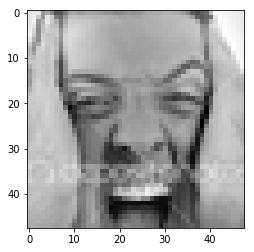

True label: Angry
Predicted label: Fear

Showing image 9


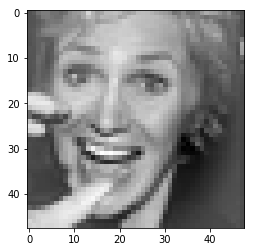

True label: Happy
Predicted label: Happy



In [16]:
def getLabel(label):
    label_index = np.argmax(label, axis=0)
    return class_labels[label_index]

best_checkpoint = 23600
test_image = 10
train_dir = "Checkpoints"
best_checkpoint_path = os.path.join(train_dir, "cnnmodel-{}".format(best_checkpoint))
class_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]


with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(train_dir)
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        # Restore the best checkpoint which is 23600
        saver.restore(session, best_checkpoint_path)
        print("Loading from the checkpoint %d" % best_checkpoint)
    else:
        print("Cannot find the checkpoint %d" % best_checkpoint)
        exit()

    # Just get the first batchsize in the private test for testing
    batch_data = test_dataset[0:batch_size, :, :, :]
    batch_labels = test_labels[0:batch_size, :]
    testing_pred = test_prediction.eval(feed_dict={keep_prob: 1.0, tf_test_dataset: batch_data})
    for img in range(test_image):
        print("Showing image %d" % img)
        showImage(batch_data[img, :, :, :])
        print("True label: %s" % getLabel(batch_labels[img, :]))
        print("Predicted label: %s" % getLabel(testing_pred[img, :]))
        print()